In [23]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import clip
from PIL import Image
import os
from collections import defaultdict
from tqdm import tqdm
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

  Cloning https://github.com/openai/CLIP.git to c:\users\admin\appdata\local\temp\pip-req-build-0tpa4czk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-0tpa4czk'


In [24]:
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate.bleu_score import corpus_bleu

In [25]:
import random

In [26]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Prepare your dataset
def load_flickr8k_data(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    # Group captions by image
    image_captions = defaultdict(list)
    for _, row in df.iterrows():
        image_captions[row['image']].append(row['caption'])

    return image_captions

class Flickr8kDataset(Dataset):
    def __init__(self, image_captions, images_dir, preprocess, tokenizer, max_length=50):
        self.images = list(image_captions.keys())
        self.captions = [image_captions[img] for img in self.images]
        self.images_dir = images_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        image = self.preprocess(image)

        # Select a random caption for this image
        caption = random.choice(self.captions[idx])

        # Tokenize caption
        caption_tokens = self.tokenizer.numericalize(caption)

        return image, caption_tokens

In [28]:
# Path configuration
CAPTIONS_FILE = 'dataset/captions.txt'  # Path to your captions.txt file
IMAGES_FOLDER = 'dataset/Images'  # Path to your images folder
CHECKPOINT_DIR = 'checkpoints'  # Directory to save model checkpoints

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [29]:
# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in nltk.tokenize.word_tokenize(sentence.lower()):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = nltk.tokenize.word_tokenize(text.lower())

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

    def decode(self, nums):
        return " ".join([self.itos[num] for num in nums])

# Dataset loading functions
def load_captions(captions_file):
    image_captions = defaultdict(list)
    with open(captions_file, 'r') as f:
        next(f)  # Skip the header row
        for line in f:
            # Split only on first comma to handle commas in captions
            parts = line.strip().split(',', 1)
            if len(parts) == 2:
                # Extract full image name (e.g., 'image_0001.jpg')
                image_name = parts[0].strip()
                caption = parts[1]
                image_captions[image_name].append(caption)

    print(f"Loaded {len(image_captions)} images with {sum(len(caps) for caps in image_captions.values())} captions")
    return image_captions

In [30]:
# Modified collate function that accepts vocab as a parameter
def collate_fn(batch, vocab):
    images, captions = zip(*batch)

    # Prepare images
    images = torch.stack(images, 0)

    # Prepare captions with padding
    captions_list = []
    for cap in captions:
        # Add <SOS> and <EOS> tokens
        cap = [vocab.stoi["<SOS>"]] + cap + [vocab.stoi["<EOS>"]]
        captions_list.append(torch.LongTensor(cap))

    # Pad captions to same length
    captions_padded = nn.utils.rnn.pad_sequence(captions_list, batch_first=True, padding_value=vocab.stoi["<PAD>"])

    return images, captions_padded

In [9]:
# CLIP + LSTM Model
class CLIPCaptionModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CLIPCaptionModel, self).__init__()

        # Linear layer to transform CLIP embedding to LSTM initial state
        self.clip_dim = 512  # CLIP ViT-B/32 has 512 dim
        self.init_h = nn.Linear(self.clip_dim, hidden_size)
        self.init_c = nn.Linear(self.clip_dim, hidden_size)

        # Embedding layer for captions
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, clip_features, captions):
        # Ensure consistent dtype - convert all to float
        clip_features = clip_features.float()

        # Generate initial LSTM states from CLIP features
        h0 = self.init_h(clip_features).unsqueeze(0)  # (1, batch_size, hidden_size)
        c0 = self.init_c(clip_features).unsqueeze(0)

        # Embed captions
        embeddings = self.embed(captions)  # (batch_size, seq_len, embed_size)
        embeddings = self.dropout(embeddings)

        # LSTM forward
        lstm_out, _ = self.lstm(embeddings, (h0, c0))  # (batch_size, seq_len, hidden_size)

        # Decode LSTM outputs
        outputs = self.fc(lstm_out)  # (batch_size, seq_len, vocab_size)

        return outputs

    def generate_caption(self, clip_features, vocab, max_length=50):
        # Ensure consistent dtype
        clip_features = clip_features.float()

        batch_size = clip_features.size(0)

        # Initialize hidden and cell states
        h = self.init_h(clip_features).unsqueeze(0)
        c = self.init_c(clip_features).unsqueeze(0)

        # Start with <SOS> token
        inputs = torch.ones(batch_size, 1).long().to(clip_features.device) * vocab.stoi["<SOS>"]  # Changed here

        # Lists to store predictions
        preds = []

        for _ in range(max_length):
            # Forward pass through the model
            embedded = self.embed(inputs)

            output, (h, c) = self.lstm(embedded, (h, c))
            output = self.fc(output.squeeze(1))

            # Get the predicted word
            predicted = output.argmax(1)

            # Add prediction to the list
            pred_item = predicted.item() if batch_size == 1 else predicted[0].item()
            preds.append(pred_item)

            # Break if <EOS> is predicted
            if pred_item == vocab.stoi["<EOS>"]:
                break

            # Update the input for the next iteration
            inputs = predicted.unsqueeze(1)

        # Return caption without <EOS>
        return [token for token in preds if token != vocab.stoi["<EOS>"]]

In [31]:
# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [32]:
# Training function
def train_epoch(model, dataloader, optimizer, criterion, clip_model, device, clip_features_cache=None):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Training")
    for i, (images, captions) in progress_bar:
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Extract CLIP features or use cached features
        if clip_features_cache is not None:
            batch_indices = list(range(i * dataloader.batch_size,
                               min((i + 1) * dataloader.batch_size, len(dataloader.dataset))))
            clip_features = clip_features_cache[batch_indices].to(device)
        else:
            with torch.no_grad():
                clip_features = clip_model.encode_image(images)

        # Forward pass
        outputs = model(clip_features, captions[:, :-1])  # Remove <EOS> token from input

        # Calculate loss
        loss = criterion(
            outputs.view(-1, outputs.size(-1)),  # Reshape outputs to (batch_size * seq_len, vocab_size)
            captions[:, 1:].contiguous().view(-1)  # Reshape captions to (batch_size * seq_len)
        )

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"batch_loss": loss.item()})

    return epoch_loss / len(dataloader)

In [33]:
# Validation function
def validate(model, dataloader, criterion, clip_model, device, clip_features_cache=None):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Validating")
        for i, (images, captions) in progress_bar:
            images = images.to(device)
            captions = captions.to(device)

            # Extract CLIP features or use cached features
            if clip_features_cache is not None:
                batch_indices = list(range(i * dataloader.batch_size,
                                  min((i + 1) * dataloader.batch_size, len(dataloader.dataset))))
                clip_features = clip_features_cache[batch_indices].to(device)
            else:
                clip_features = clip_model.encode_image(images)

            # Forward pass
            outputs = model(clip_features, captions[:, :-1])

            # Calculate loss
            loss = criterion(
                outputs.view(-1, outputs.size(-1)),  # Reshape outputs to (batch_size * seq_len, vocab_size)
                captions[:, 1:].contiguous().view(-1)  # Reshape captions to (batch_size * seq_len)
            )

            val_loss += loss.item()
            progress_bar.set_postfix({"batch_loss": loss.item()})

    return val_loss / len(dataloader)

In [34]:
# Function to pre-compute and cache CLIP features
def cache_clip_features(dataset, dataloader, clip_model, device):
    clip_features = torch.zeros(len(dataset), clip_model.visual.output_dim, dtype=torch.float32)

    with torch.no_grad():
        for i, (images, _) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Caching CLIP features"):
            batch_size = images.size(0)
            batch_indices = list(range(i * dataloader.batch_size,
                               min((i + 1) * dataloader.batch_size, len(dataset))))

            images = images.to(device)
            features = clip_model.encode_image(images).cpu()

            clip_features[batch_indices] = features.type(torch.float32)

    return clip_features

In [ ]:
# # Evaluation function
# def evaluate_model(model, dataloader, vocab, clip_model, device, num_samples=5):
#     model.eval()
#     all_images = []
#     all_ground_truth = []
#     all_generated = []

#     with torch.no_grad():
#         for images, captions in dataloader:
#             if len(all_images) >= num_samples:
#                 break

#             images = images.to(device)

#             # Extract CLIP features
#             clip_features = clip_model.encode_image(images)

#             # Generate captions
#             for i in range(min(len(images), num_samples - len(all_images))):
#                 img_feature = clip_features[i:i+1]

#                 # Generate caption
#                 pred_indices = model.generate_caption(img_feature, vocab)
#                 pred_caption = vocab.decode(pred_indices)

#                 # Get ground truth caption
#                 true_tokens = [idx.item() for idx in captions[i][1:]
#                               if idx.item() not in [vocab.stoi["<PAD>"],
#                                                  vocab.stoi["<SOS>"],
#                                                  vocab.stoi["<EOS>"]]]
#                 true_caption = vocab.decode(true_tokens)

#                 all_images.append(images[i].cpu())
#                 all_ground_truth.append(true_caption)
#                 all_generated.append(pred_caption)

#     # Display results
#     for i in range(len(all_images)):
#         print(f"Example {i+1}:")
#         print(f"Ground truth: {all_ground_truth[i]}")
#         print(f"Generated: {all_generated[i]}")
#         print("-" * 50)

#     return all_images, all_ground_truth, all_generated

In [40]:
# Updated evaluate_model function to display images
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, vocab, clip_model, device, num_samples=5):
    model.eval()
    all_images = []
    all_ground_truth = []
    all_generated = []

    with torch.no_grad():
        for images, captions in dataloader:
            if len(all_images) >= num_samples:
                break

            images = images.to(device)

            # Extract CLIP features
            clip_features = clip_model.encode_image(images)

            # Generate captions
            for i in range(min(len(images), num_samples - len(all_images))):
                img_feature = clip_features[i:i+1]

                # Generate caption
                pred_indices = model.generate_caption(img_feature, vocab)
                pred_caption = vocab.decode(pred_indices)

                # Get ground truth caption
                true_tokens = [idx.item() for idx in captions[i][1:]
                              if idx.item() not in [vocab.stoi["<PAD>"],
                                                 vocab.stoi["<SOS>"],
                                                 vocab.stoi["<EOS>"]]]
                true_caption = vocab.decode(true_tokens)

                all_images.append(images[i].cpu())
                all_ground_truth.append(true_caption)
                all_generated.append(pred_caption)

    # Display results with images
    for i in range(len(all_images)):
        plt.figure(figsize=(5, 5))
        image = all_images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Generated: {all_generated[i]}\nGround Truth: {all_ground_truth[i]}")
        plt.show()

    return all_images, all_ground_truth, all_generated

In [43]:
def show_example_captions(model, dataloader, vocab, clip_model, device,
                          images_dir, num_samples=5, beam_size=5, length_penalty=1.0):
    """
    For up to num_samples images in dataloader, display the original image,
    the ground‐truth caption and the model’s beam‐search caption.
    """
    model.eval()
    shown = 0
    with torch.no_grad():
        for batch_idx, (images, captions) in enumerate(dataloader):
            images = images.to(device)
            clip_feats = clip_model.encode_image(images).float()

            for j in range(images.size(0)):
                if shown >= num_samples:
                    return
                # compute global index so we can lookup filename
                global_idx = batch_idx * dataloader.batch_size + j
                img_name = dataloader.dataset.images[global_idx]
                img_path = os.path.join(images_dir, img_name)

                # load and show original
                pil_img = Image.open(img_path).convert("RGB")

                # generate
                pred_idxs = model.generate_caption_beam_search(
                    clip_feats[j:j+1], vocab, beam_size=beam_size, length_penalty=length_penalty
                )
                pred_caption = vocab.decode(pred_idxs)

                # ground truth
                # skip <SOS>, <PAD>, stop at <EOS>
                gt_idxs = captions[j].tolist()
                gt_tokens = []
                for t in gt_idxs[1:]:
                    if t == vocab.stoi["<EOS>"]:
                        break
                    if t not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"]}:
                        gt_tokens.append(vocab.itos[t])
                gt_caption = " ".join(gt_tokens)

                # plot
                plt.figure(figsize=(4,4))
                plt.imshow(pil_img)
                plt.axis('off')
                plt.title(f"GT: {gt_caption}\nP: {pred_caption}", fontsize=10)
                plt.show()

                shown += 1

In [ ]:
# # Function to calculate BLEU scores
# def calculate_bleu_scores(model, dataloader, vocab, clip_model, device):
#     model.eval()
#     references = []
#     hypotheses = []

#     with torch.no_grad():
#         for images, captions in tqdm(dataloader, desc="Calculating BLEU scores"):
#             images = images.to(device)

#             # Extract CLIP features
#             clip_features = clip_model.encode_image(images)

#             # Generate captions for each image
#             for i in range(len(images)):
#                 img_feature = clip_features[i:i+1]

#                 # Generate caption
#                 pred_indices = model.generate_caption(img_feature, vocab)
#                 pred_caption = [vocab.itos[idx] for idx in pred_indices
#                                if idx not in [vocab.stoi["<PAD>"],
#                                              vocab.stoi["<SOS>"],
#                                              vocab.stoi["<EOS>"]]]

#                 # Get reference caption
#                 reference = []
#                 for j in range(1, len(captions[i])):  # Skip <SOS>
#                     idx = captions[i][j].item()
#                     if idx == vocab.stoi["<EOS>"]:
#                         break
#                     if idx != vocab.stoi["<PAD>"]:
#                         reference.append(vocab.itos[idx])

#                 references.append([reference])
#                 hypotheses.append(pred_caption)

#     # Calculate BLEU scores
#     bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
#     bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
#     bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
#     bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

#     print(f"BLEU-1: {bleu1:.4f}")
#     print(f"BLEU-2: {bleu2:.4f}")
#     print(f"BLEU-3: {bleu3:.4f}")
#     print(f"BLEU-4: {bleu4:.4f}")

#     return bleu1, bleu2, bleu3, bleu4

In [37]:
def generate_caption_for_image(image_path, model, clip_model, preprocess, vocab, device):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image).unsqueeze(0).to(device)

    # Extract CLIP features
    with torch.no_grad():
        clip_features = clip_model.encode_image(image)

    # Generate caption
    model.eval()
    pred_indices = model.generate_caption(clip_features, vocab)
    pred_caption = vocab.decode(pred_indices)

    return pred_caption

In [21]:

def load_flickr30k_data(captions_file, images_dir):
    """
    Reads a CSV of lines like:
      1000092795.jpg,0,Two young guys with shaggy hair…
    """
    image_captions = defaultdict(list)
    with open(captions_file, 'r', encoding='utf-8', errors='ignore') as f:
        next(f)
        for line in f:
            line = line.strip()
            if not line:
                continue
            # split into image_name, comment_number (ignored), caption
            image_name, _, caption = line.split(',', 2)
            image_captions[image_name].append(caption)
    return image_captions

class Flickr30kDataset(Dataset):
    def __init__(self, image_captions, images_dir, preprocess, tokenizer, max_length=50):
        self.images      = list(image_captions.keys())
        self.captions    = [image_captions[i] for i in self.images]
        self.images_dir  = images_dir
        self.preprocess  = preprocess
        self.tokenizer   = tokenizer
        self.max_length  = max_length

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image    = Image.open(img_path).convert("RGB")
        image    = self.preprocess(image)

        # pick one of the 5 captions at random
        caption = random.choice(self.captions[idx])
        # tokenize → list[int]
        caption_tokens = self.tokenizer.numericalize(caption)

        return image, caption_tokens

In [42]:
# Updated CLIP+LSTM Model with Attention
class CLIPCaptionModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, attention=True, dropout=0.5,
                 clip_dim=None, clip_model=None):
        super(CLIPCaptionModel, self).__init__()

        # CLIP feature dimension
        #self.clip_dim = 512
        # CLIP feature dimension (allow override or use clip_model's visual output dimension)
        self.clip_dim = clip_dim if clip_dim is not None else clip_model.visual.output_dim

        # Attention mechanism
        self.use_attention = attention

        # Embedding layer for captions
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM layers
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Linear layers to transform CLIP features
        # self.init_h = nn.Linear(self.clip_dim, hidden_size * num_layers)
        # self.init_c = nn.Linear(self.clip_dim, hidden_size * num_layers)
        self.init_h = nn.Linear(self.clip_dim,
                               self.lstm.hidden_size * self.lstm.num_layers)
        self.init_c = nn.Linear(self.clip_dim,
                               self.lstm.hidden_size * self.lstm.num_layers)

        # Attention layers (if used)
        if self.use_attention:
            self.attention = nn.Linear(hidden_size + self.clip_dim, 1)
            self.caption_context = nn.Linear(hidden_size + self.clip_dim, hidden_size)

        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def init_hidden_states(self, clip_features):
        # # Ensure float32 precision
        # clip_features = clip_features.float()

        # # Initialize LSTM hidden and cell states
        # h0 = self.init_h(clip_features)
        # c0 = self.init_c(clip_features)

        # # Reshape for multi-layer LSTM (num_layers, batch_size, hidden_size)
        # h0 = h0.view(self.lstm.num_layers, batch_size, self.lstm.hidden_size)
        # c0 = c0.view(self.lstm.num_layers, batch_size, self.lstm.hidden_size)

        # return h0, c0
        """
        Project CLIP features → (batch, hidden_size * num_layers),
        then reshape → (num_layers, batch, hidden_size).
        """
        batch_size = clip_features.size(0)
        # project
        h = self.init_h(clip_features.float())  # (B, H*L)
        c = self.init_c(clip_features.float())  # (B, H*L)
        # figure out dims
        n_layers = self.lstm.num_layers
        total_dim = h.size(1)                  # H*L
        hidden_size = total_dim // n_layers    # H
        # reshape: (B, L, H) → permute → (L, B, H)
        h = (h.view(batch_size, n_layers, hidden_size)
               .permute(1, 0, 2)
               .contiguous())
        c = (c.view(batch_size, n_layers, hidden_size)
               .permute(1, 0, 2)
               .contiguous())
        return h, c

    def forward(self, clip_features, captions):
        # Get batch size and sequence length
        batch_size = captions.size(0)

        # Initialize hidden states
        h0, c0 = self.init_hidden_states(clip_features)

        # Embed captions
        embeddings = self.dropout(self.embed(captions))

        # LSTM forward
        lstm_outputs, _ = self.lstm(embeddings, (h0, c0))

        # Apply attention if enabled
        if self.use_attention:
            # Expand CLIP features to match sequence length
            clip_features_expanded = clip_features.unsqueeze(1).expand(
                -1, lstm_outputs.size(1), -1
            )  # (B, T, C)

            # Concatenate LSTM outputs with CLIP features
            combined = torch.cat((lstm_outputs, clip_features_expanded), dim=2)  # (B, T, H+C)

            # Compute attention scores & weights over time
            attn_scores  = self.attention(combined)         # (B, T, 1)
            attn_weights = F.softmax(attn_scores, dim=1)    # (B, T, 1)

            # Fuse features per time-step
            fused = self.caption_context(combined)          # (B, T, hidden)

            # Produce logits at each time-step
            outputs = self.fc(fused)                        # (B, T, vocab_size)
        else:
            outputs = self.fc(lstm_outputs)                 # (B, T, vocab_size)

        return outputs

    # Implement beam search for better generation
    def generate_caption_beam_search(self, clip_features, vocab, beam_size=5, max_length=50
                                     , length_penalty=1.0, repetition_penalty=1.2):
        # Ensure model in eval mode
        self.eval()

        # Move to same device as model
        device = next(self.parameters()).device

        # Initialize hidden states
        h, c = self.init_hidden_states(clip_features)

        # Start with SOS token
        k = beam_size
        sequences = [([vocab.stoi["<SOS>"]], 0.0, (h, c))]

        # Beam search loop
        for _ in range(max_length):
            all_candidates = []

            # Expand each current candidate
            for seq, score, (h_state, c_state) in sequences:
                if seq[-1] == vocab.stoi["<EOS>"]:
                    # Keep completed sequences
                    all_candidates.append((seq, score, (h_state, c_state)))
                    continue

                # Forward current token through model
                input_tensor = torch.LongTensor([seq[-1]]).unsqueeze(0).to(device)
                embedded = self.embed(input_tensor)

                # LSTM step
                out, (h_new, c_new) = self.lstm(embedded, (h_state, c_state))

                # Get predictions
                if self.use_attention:
                    clip_exp = clip_features.unsqueeze(1)
                    combined = torch.cat((out, clip_exp), dim=2)
                    fused = self.caption_context(combined)
                    predictions = self.fc(fused.squeeze(1))
                else:
                    predictions = self.fc(out.squeeze(1))

                log_probs = F.log_softmax(predictions, dim=1)

                # ← apply repetition penalty
                for token in set(seq):
                    log_probs[0, token] /= repetition_penalty

                topk_probs, topk_ids = log_probs.topk(k)

                # Create new candidates
                for i in range(k):
                    next_token = topk_ids[0, i].item()
                    next_score = score + topk_probs[0, i].item()
                    new_seq = seq + [next_token]
                    all_candidates.append((new_seq, next_score, (h_new, c_new)))

            # Select k best candidates
            sequences = sorted(all_candidates, 
                               key=lambda x: x[1] / (len(x[0])**length_penalty if len(x[0]) > 0 else 1.0),
                               reverse=True)[:k]

            # Stop if all sequences end with EOS
            if all(seq[-1] == vocab.stoi["<EOS>"] for seq, _, _ in sequences):
                break

        # Return best sequence without SOS and EOS
        best_seq = sequences[0][0]
        return [token for token in best_seq if token not in
                [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]


In [45]:
def calculate_bleu_scores(model, dataloader, vocab, clip_model, device, beam_size=5):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc="Calculating BLEU scores"):
            images = images.to(device)

            # Extract CLIP features
            clip_features = clip_model.encode_image(images)

            # Generate captions for each image
            for i in range(len(images)):
                img_feature = clip_features[i:i+1]

                # Generate caption using beam search
                pred_indices = model.generate_caption_beam_search(
                    img_feature, vocab, beam_size=beam_size
                )
                pred_caption = [vocab.itos[idx] for idx in pred_indices
                               if idx not in [vocab.stoi["<PAD>"],
                                              vocab.stoi["<SOS>"],
                                              vocab.stoi["<EOS>"]]]

                # Get reference caption
                reference = []
                for j in range(1, len(captions[i])):  # Skip <SOS>
                    idx = captions[i][j].item()
                    if idx == vocab.stoi["<EOS>"]:
                        break
                    if idx != vocab.stoi["<PAD>"]:
                        reference.append(vocab.itos[idx])

                references.append([reference])
                hypotheses.append(pred_caption)

    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")

    return bleu1, bleu2, bleu3, bleu4

In [ ]:
# Main function
def main():
    # Config
    embed_size = 256
    hidden_size = 512
    batch_size = 32
    learning_rate = 3e-4
    num_epochs = 15
    use_clip_cache = True  # Set to True to cache CLIP features, False otherwise
    early_stopping_patience = 2

    # Load captions
    #image_captions = load_captions(CAPTIONS_FILE)
    image_captions = load_flickr8k_data(CAPTIONS_FILE, IMAGES_FOLDER)

    # Create vocabulary
    all_captions = []
    for captions in image_captions.values():
        all_captions.extend(captions)

    vocab = Vocabulary(freq_threshold=5)
    vocab.build_vocabulary(all_captions)
    print(f"Vocabulary size: {len(vocab)}")

    # Split dataset into train/val/test
    image_keys = list(image_captions.keys())
    random.shuffle(image_keys)

    # 80% train, 10% val, 10% test
    train_size = int(0.8 * len(image_keys))
    val_size = int(0.1 * len(image_keys))

    train_keys = image_keys[:train_size]
    val_keys = image_keys[train_size:train_size+val_size]
    test_keys = image_keys[train_size+val_size:]

    train_image_captions = {k: image_captions[k] for k in train_keys}
    val_image_captions = {k: image_captions[k] for k in val_keys}
    test_image_captions = {k: image_captions[k] for k in test_keys}

    # Create datasets
    # train_dataset = Flickr8kDataset(train_image_captions, IMAGES_FOLDER, preprocess, vocab)
    # val_dataset = Flickr8kDataset(val_image_captions, IMAGES_FOLDER, preprocess, vocab)
    # test_dataset = Flickr8kDataset(test_image_captions, IMAGES_FOLDER, preprocess, vocab)
    train_dataset = Flickr8kDataset(train_image_captions, IMAGES_FOLDER, preprocess, vocab) # Changed here
    val_dataset = Flickr8kDataset(val_image_captions, IMAGES_FOLDER, preprocess, vocab) # Changed here
    test_dataset = Flickr8kDataset(test_image_captions, IMAGES_FOLDER, preprocess, vocab)
    # Create dataloaders with properly parameterized collate_fn
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, vocab)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, vocab)
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, vocab)
    )

    # Cache CLIP features if enabled
    train_clip_features = None
    val_clip_features = None
    if use_clip_cache:
        print("Caching CLIP features...")
        train_clip_features = cache_clip_features(train_dataset, train_loader, clip_model, device)
        val_clip_features = cache_clip_features(val_dataset, val_loader, clip_model, device)
        print("CLIP features cached!")

    # Initialize model
    model = CLIPCaptionModel(embed_size, hidden_size, len(vocab)).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    epochs_no_improve = 0 # Add this line

    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip_model, device, train_clip_features)
        train_losses.append(train_loss)

        # Validate
        val_loss = validate(model, val_loader, criterion, clip_model, device, val_clip_features)
        val_losses.append(val_loss)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        # Save checkpoint if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'vocab_itos': vocab.itos,
                'vocab_stoi': vocab.stoi,
            }, checkpoint_path)
            print(f"Model saved to {checkpoint_path}!")
            epochs_no_improve = 0 # Reset counter
        else: # Add this block
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {early_stopping_patience} epochs with no improvement.")
                break # Stop training

        # Regular checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'vocab_itos': vocab.itos,
            'vocab_stoi': vocab.stoi,
        }, checkpoint_path)

        print("-" * 50)

    # Plot training and validation loss
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    epochs_completed = len(train_losses)  # Use the actual number of completed epochs
    plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'loss_plot.png'))
    plt.close()

    # Evaluate on test set
    print("Evaluating model on test set...")
    # Load best model for evaluation
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, "best_model.pth"))
    model.load_state_dict(checkpoint['model_state_dict'])

    # Generate some example captions
    print("Generating example captions...")
    evaluate_model(model, test_loader, vocab, clip_model, device, num_samples=5)

    # Calculate BLEU scores
    print("Calculating BLEU scores...")
    calculate_bleu_scores(model, test_loader, vocab, clip_model, device)

if __name__ == "__main__":
    main()

Vocabulary size: 3005
Caching CLIP features...


Caching CLIP features: 100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


CLIP features cached!
Starting training...
Epoch 1/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  3.82it/s, batch_loss=4.05]


Training Loss: 4.7545
Validation Loss: 4.0866
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 2/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.13it/s, batch_loss=3.37]


Training Loss: 3.9551
Validation Loss: 3.7660
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 3/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  3.90it/s, batch_loss=3.14]


Training Loss: 3.7185
Validation Loss: 3.5272
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 4/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.25it/s, batch_loss=3.1] 


Training Loss: 3.5718
Validation Loss: 3.4607
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 5/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.06it/s, batch_loss=2.79]


Training Loss: 3.4639
Validation Loss: 3.3262
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 6/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.04it/s, batch_loss=3.44]


Training Loss: 3.3851
Validation Loss: 3.2855
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 7/15


Validating: 100%|██████████| 26/26 [00:05<00:00,  4.97it/s, batch_loss=2.96]


Training Loss: 3.3216
Validation Loss: 3.2566
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 8/15


Validating: 100%|██████████| 26/26 [00:05<00:00,  4.40it/s, batch_loss=3.18]


Training Loss: 3.2754
Validation Loss: 3.2482
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 9/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.33it/s, batch_loss=2.35]


Training Loss: 3.2376
Validation Loss: 3.1911
Model saved to checkpoints\best_model.pth!
--------------------------------------------------
Epoch 10/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.05it/s, batch_loss=3.36]


Training Loss: 3.2058
Validation Loss: 3.2120
--------------------------------------------------
Epoch 11/15


Validating: 100%|██████████| 26/26 [00:06<00:00,  4.08it/s, batch_loss=3.45]


Training Loss: 3.1644
Validation Loss: 3.1955
Early stopping triggered after 2 epochs with no improvement.
Evaluating model on test set...
Generating example captions...


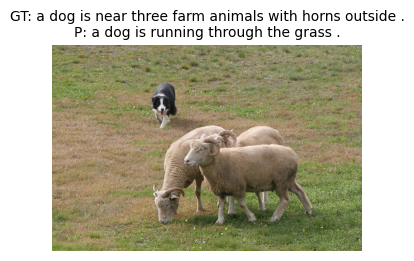

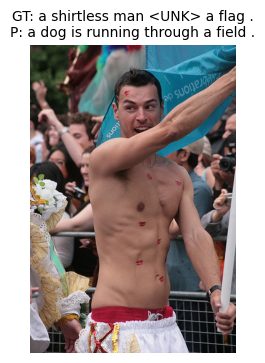

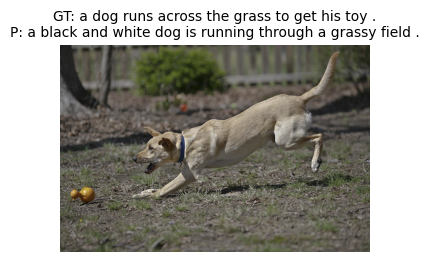

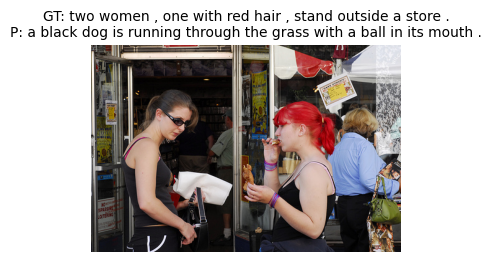

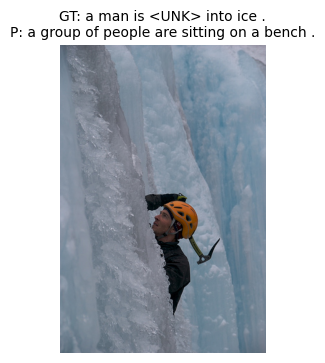

Calculating BLEU scores...


Calculating BLEU scores: 100%|██████████| 26/26 [01:08<00:00,  2.65s/it]


BLEU-1: 0.2706
BLEU-2: 0.0850
BLEU-3: 0.0382
BLEU-4: 0.0201


In [46]:
def main():
    # Config
    embed_size = 256
    hidden_size = 512
    batch_size = 32
    learning_rate = 3e-4
    num_epochs = 15
    use_clip_cache = True  # Set to True to cache CLIP features, False otherwise
    early_stopping_patience = 2
    attention = True  # Enable attention mechanism
    beam_size = 5  # Beam size for caption generation

    # Load captions
    image_captions = load_flickr8k_data(CAPTIONS_FILE, IMAGES_FOLDER)

    # Create vocabulary
    all_captions = []
    for captions in image_captions.values():
        all_captions.extend(captions)

    vocab = Vocabulary(freq_threshold=5)
    vocab.build_vocabulary(all_captions)
    print(f"Vocabulary size: {len(vocab)}")

    # Split dataset into train/val/test
    image_keys = list(image_captions.keys())
    random.shuffle(image_keys)

    # 80% train, 10% val, 10% test
    train_size = int(0.8 * len(image_keys))
    val_size = int(0.1 * len(image_keys))

    train_keys = image_keys[:train_size]
    val_keys = image_keys[train_size:train_size+val_size]
    test_keys = image_keys[train_size+val_size:]

    train_image_captions = {k: image_captions[k] for k in train_keys}
    val_image_captions = {k: image_captions[k] for k in val_keys}
    test_image_captions = {k: image_captions[k] for k in test_keys}

    # Create datasets
    train_dataset = Flickr8kDataset(train_image_captions, IMAGES_FOLDER, preprocess, vocab)
    val_dataset = Flickr8kDataset(val_image_captions, IMAGES_FOLDER, preprocess, vocab)
    test_dataset = Flickr8kDataset(test_image_captions, IMAGES_FOLDER, preprocess, vocab)

    # Create dataloaders with properly parameterized collate_fn
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, vocab)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, vocab)
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, vocab)
    )

    # Cache CLIP features if enabled
    train_clip_features = None
    val_clip_features = None
    if use_clip_cache:
        print("Caching CLIP features...")
        train_clip_features = cache_clip_features(train_dataset, train_loader, clip_model, device)
        val_clip_features = cache_clip_features(val_dataset, val_loader, clip_model, device)
        print("CLIP features cached!")

    # Initialize model
    model = CLIPCaptionModel(
        embed_size=embed_size,
        hidden_size=hidden_size,
        vocab_size=len(vocab),
        num_layers=2,
        attention=attention,
        clip_dim=clip_model.visual.output_dim,
        clip_model=clip_model
    ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    epochs_no_improve = 0

    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip_model, device, train_clip_features)
        train_losses.append(train_loss)

        # Validate
        val_loss = validate(model, val_loader, criterion, clip_model, device, val_clip_features)
        val_losses.append(val_loss)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        # Save checkpoint if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'vocab_itos': vocab.itos,
                'vocab_stoi': vocab.stoi,
            }, checkpoint_path)
            print(f"Model saved to {checkpoint_path}!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {early_stopping_patience} epochs with no improvement.")
                break

        # Regular checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'vocab_itos': vocab.itos,
            'vocab_stoi': vocab.stoi,
        }, checkpoint_path)

        print("-" * 50)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    epochs_completed = len(train_losses)
    plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(CHECKPOINT_DIR, 'loss_plot.png'))
    plt.close()

    # Evaluate on test set
    print("Evaluating model on test set...")
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, "best_model.pth"))
    model.load_state_dict(checkpoint['model_state_dict'])

    # Generate some example captions with beam search
    print("Generating example captions...")
    #evaluate_model(model, test_loader, vocab, clip_model, device, num_samples=5)
    show_example_captions(model, test_loader, vocab, clip_model, device,
                          IMAGES_FOLDER, num_samples=5, beam_size=beam_size)

    # Calculate BLEU scores
    print("Calculating BLEU scores...")
    calculate_bleu_scores(model, test_loader, vocab, clip_model, device)

if __name__ == "__main__":
    main()